# Part I: Inverse Problems and Model-Driven Reconstruction

Welcome to the tutorial to the course **"Regularization in Image Reconstruction: From Model to Data Driven Methods"**! ☀

Image reconstruction is a so-called inverse problem where we want to reconstruct an image from some (noisy) measurement data.

In the first part, we will fix the notation of our inverse problem, see some typical applications and find out what can go wrong with a naive inversion. Finally, we will see some classical approaches for a more "controlled" reonstruction called regularized inversion.

## Notation
Each inverse problem is connected to a forward problem. The forward problems we will look at can be described by a **linear forward operator** $A$ that maps the **ground truth data** $x$ to a **measurement** $y^{\delta}$ which is additionally corrupted by some unknown **noise $\epsilon$**. We thus write 
$$y^{\delta} = Ax + \epsilon.$$
The subscript $\delta$ indicates that the noise $\epsilon$ is bounded by a **noise level** $\delta > 0$ in some way. We will bound the norm of the noiselike
$$ \| \epsilon \| \leq \delta.$$

## Examples

Before we start with the hands on examples, we have to import some basic Python packages and load our first example image: a modern version of the famous cameraman.

In [2]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
import ipywidgets as widgets 
from ipywidgets import interactive

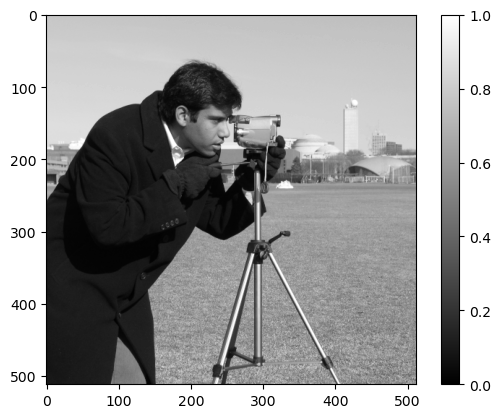

In [3]:
img = ski.img_as_float(ski.data.camera())
plt.imshow(img, cmap='gray')
plt.colorbar()

### <span style="color:cornflowerblue"> Example 1:  Color Negation </span>
Looking at the colorbar next to the image we see that its grey values are included in the interval $[0,1]$. We can produce the so-called **negative image** by negating its grey values.

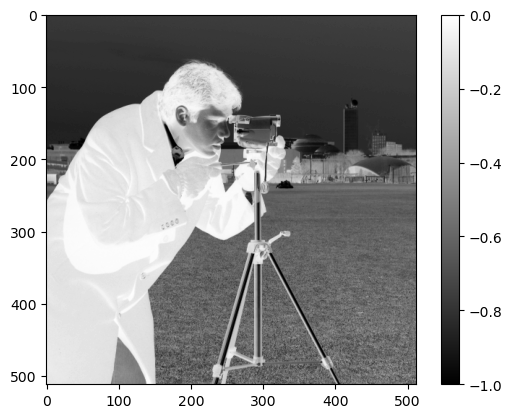

In [4]:
# forward operator for color negation
def negate_colors(img):
    return -img

# compute the negative image of our example image
negative = negate_colors(img)

plt.imshow(negative, cmap='gray')
plt.colorbar()

### &#128221; <span style="color:darkorange">Task 1.1</span>
#### Which forward operator $A$ describes the color negation problem?

### &#128221; <span style="color:darkorange">Task 1.2</span>
#### Complete the following function which inverts the color negation, i.e., takes a negative image as an input and returns the corresponding positive image.

In [5]:
def invert_color_negation(negative):
    positive = None # [subsitute "None" by your own code] 
    return positive

#### Let's see if it works:

TypeError: Image data of dtype object cannot be converted to float

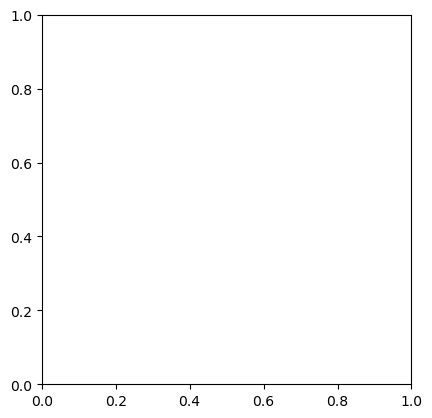

In [6]:
positive = invert_color_negation(negative)

plt.imshow(positive, cmap='gray')
plt.colorbar()

### <span style="color:cornflowerblue"> Example 2:  Computed Tomography </span>

Computed Tomography scans are a popular way to obtain internal images of the body. Roughly speaking, it works by sending X-rays through the body from different directions. While travelling through the body, the X-rays are damped depending on the densities of the materials they pass through. This intensity decay is then measured on the opposite side of the body. The collection of all measurements is called **sinogram**. 

Let's look at an exemplary CT scan of the [Shepp-Logan phantom](https://en.wikipedia.org/wiki/Shepp–Logan_phantom)!

In [8]:

phantom = ski.data.shepp_logan_phantom()
theta = np.linspace(0,180, endpoint = False, num=400)
sinogram =  ski.transform.radon(phantom, theta)
ray_pos = np.arange(20, 400, step=20)

def plot_at_angle(angle):
    fig, axs = plt.subplots(1, 3)
    rot = ski.transform.rotate(phantom, angle)
    rot[:,ray_pos] = 1
    projection = sinogram[:,angle]
    sino = np.zeros((400,400))
    sino[:,:angle] = sinogram[:,:angle]
    axs[0].imshow(rot, cmap = 'gray')
    axs[1].plot(np.arange(400), projection)
    axs[2].imshow(sino, cmap = 'gray')

slider = widgets.IntSlider(min = 0, max = 399, step = 1, value = 0, continuous_update = True)
interactive_plot = interactive(plot_at_angle, angle = slider)
interactive_plot

    

#projection =
#rot = ski.transform.rotate(phantom, angle = 10)
#plt.imshow(rot)

interactive(children=(IntSlider(value=0, description='angle', max=399), Output()), _dom_classes=('widget-inter…

In [ ]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])